<h1 align=center><font size = 5>Café B2D: Toronto, ON</font></h1>

## Table of contents

<div style="background-color:#f2f2f2; margin-top:25px;padding:10px;">
    
1. [Introduction](#introduction)<br>
2. [Data](#data)<br>
3. [Methodology](#methodology)<br>
4. [Analysis](#analysis)<br>
5. [Results and Discussion](#results)<br>
6. [Conclusion](#conclusion)<br>
</div>
<hr>

<div style="background-color:#f2f2f2; padding:5px;"><h2>1. Introduction <a name="introduction"/></div>

**Café B2D** *(Bean 2 Drip)* is an up-and-coming café specializing in high end coffee related drinks and exceptional pastries and made-to-order items.  As they are preparing for their launch into Toronto, they are uncertain as to the area in which the should set up shop.  The primary criteria that they require from the right neighbourhood is as follows:

1. Average income within the neighbourhood must be over $150,000/year
2. Location to not be near moderate or higher cost venues
3. Location to not be within an area that is overly saturated with other venues
4. The population within the neighbourhood (including surrounding neighbourhoods within 1000m) needs to be in excess of 7,500

The following data analysis will provide **Café B2D** with a recommended location as well as two runner ups.

<hr>

<div style="background-color:#f2f2f2; padding:5px;"><h2>2. Data <a name="data"/></div>

The data that will be used within the analysis will include:

1. Retrieve data on the Toronto neighbourhoods: 
    * Data is located at: https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/ef0239b1-832b-4d0b-a1f3-4153e53b189e?format=csv
    * Contains name, population, land area and average income
    * Data at this point can be filtered to match the necessary criteria
2. Retrieve the longitude and latitude for each of the neighbourhoods:
    * Data is located at https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/a083c865-6d60-4d1d-b6c6-b0c8a85f9c15?format=csv&projection=4326
    * Merge with the neighbourhood data once complete
3. Retrieve the geojson data for the Toronto neighbourhoods:
    * Data is located at https://raw.githubusercontent.com/jasonicarter/toronto-geojson/master/toronto_crs84.geojson
    * This will allow the map to highlight the neighbourhoods that are acceptable and grey out the neighbourhoods that do not meet the criteria 
4. Retrieve the venue data from Foursquare for all the relevant coffece shops within each of the neighbourhoods
    * Will use the land area from the Toronto neighbourhoods to determine a radius to use
    * Count of venues within the neighbourhood, grouped by cost

With the retrieved data, we will:

1. Locate the neighbourhoods that fit the requirements set out by **Café B2D**
2. Visually show the neighbourhoods
3. Visually show the Foursquare venues
2. Calculate the saturation of coffee shops within each neighbourhood (population divided by count of shops provides average population per shop)
2. A recommended list of three potential areas, ranked in order including a visual map of where it should be
    
<hr>

### Load the required libraries

Import the necessary dependencies for the notebook

In [ ]:
# Import pandas 
import pandas as pd

# Import numpy
import numpy as np

# Import library to handle requests 
import requests

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# Matplotlib and plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 
%matplotlib inline 

# Import the kmeans for the clustering stage
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs

# Map rendering library
!conda install -c conda-forge folium=0.5.0 --yes
import folium

import math

print("Libraries have been imported")

Solving environment: / 

### Collect the Demographic data

Going to collect the demographic data from the Toront open data platform and select the required columns of neighbourhood, neighbourhood number, population, land area, and average income

In [2]:
# Get the demographic details from the city of Toronto open data platform
df_csv = pd.read_csv("https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/ef0239b1-832b-4d0b-a1f3-4153e53b189e?format=csv")

# Remove some of the unnecessary columns
df_csv.drop(df_csv.columns[[0,1,2,3]], axis=1, inplace=True)

# Rename and set the Characteristic column as the index
df_csv.rename(columns={"Characteristic":"id"}, inplace=True)
df_csv.set_index("id", inplace=True)

# Transpose the data so it will be easier to work with
df_csv = df_csv.T
df_csv = df_csv.reset_index()
df_csv.rename(columns={"index":"Neighbourhood"}, inplace=True)
df_csv = df_csv[df_csv["Neighbourhood"] != "City of Toronto"].reset_index(drop=True)

# Copy a subset of the data into the working dataframe
df_dem = df_csv[["Neighbourhood","Neighbourhood Number","Population, 2016","Land area in square kilometres","Total income: Average amount ($)"]]

df_dem.head()

id                 Neighbourhood Neighbourhood Number Population, 2016  \
0                Agincourt North                  129           29,113   
1   Agincourt South-Malvern West                  128           23,757   
2                      Alderwood                   20           12,054   
3                          Annex                   95           30,526   
4              Banbury-Don Mills                   42           27,695   

id Land area in square kilometres Total income: Average amount ($)  
0                            7.41                           30,414  
1                            7.83                           31,825  
2                            4.95                           47,709  
3                            2.81                          112,766  
4                            9.98                           67,757

### Collect the Geographic data

Collect the geographic data from the Toronto open data platform and select the required columns of the code, longitude and latitude

In [3]:
# Get the geographic data from the city of Toronto open data platform
df_area_data = pd.read_csv("https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/a083c865-6d60-4d1d-b6c6-b0c8a85f9c15?format=csv&projection=4326")

# Select just the necessary data
df_geo = df_area_data[["AREA_SHORT_CODE","LONGITUDE","LATITUDE"]]

# Rename the necessary data
df_geo.rename(columns={"AREA_SHORT_CODE":"ID Number", "LONGITUDE":"Longitude","LATITUDE":"Latitude"}, inplace=True)
df_geo.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


ID Number  Longitude   Latitude
0         94 -79.425515  43.676919
1        100 -79.403590  43.704689
2         97 -79.397871  43.687859
3         27 -79.488883  43.765736
4         31 -79.457108  43.714672

### Clean the Data

At this point we can clean the data so that it will be more useable throughout the rest of the notebook

In [4]:
# Rename the columns to make it easier to work with
df_dem.columns = ["Name", "ID Number", "Population", "Land Area", "Average Income"]

# Reformat the column types to be used for other purposes
df_dem.loc[:,"Population"] = df_dem["Population"].str.replace(',','')
df_dem.loc[:,"Average Income"] = df_dem["Average Income"].str.replace(',','')

# Update field types for use in formulas
df_dem = df_dem.astype({"Population": float, "Land Area":float, "Average Income":float})

# Add the radius for the Foursqure search
df_dem["Radius"] = df_dem["Land Area"]**(1/2)*1000/2
df_dem = df_dem.round({"Radius":0})

# Add a link that will be required for the geojson data
df_dem["Link"] = df_dem["Name"] + " (" + df_dem["ID Number"] + ")"

# Update the ID Number to be integer 
df_dem = df_dem.astype({"ID Number" : int})

# Merge the geographic data with the demographic data
df_dem = pd.merge(df_dem, df_geo, on="ID Number")
df_dem.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Name  ID Number  Population  Land Area  \
0               Agincourt North        129     29113.0       7.41   
1  Agincourt South-Malvern West        128     23757.0       7.83   
2                     Alderwood         20     12054.0       4.95   
3                         Annex         95     30526.0       2.81   
4             Banbury-Don Mills         42     27695.0       9.98   

   Average Income  Radius                                Link  Longitude  \
0         30414.0  1361.0               Agincourt North (129) -79.266712   
1         31825.0  1399.0  Agincourt South-Malvern West (128) -79.265612   
2         47709.0  1112.0                      Alderwood (20) -79.541611   
3        112766.0   838.0                          Annex (95) -79.404001   
4         67757.0  1580.0              Banbury-Don Mills (42) -79.349718   

    Latitude  
0  43.805441  
1  43.788658  
2  43.604937  
3  43.671585  
4  43.737657

### Filter the data to the income requirement stated in the introduction

With the data that's been collected and cleaned, the filtering of the income can be applied (greater than or equal to $150,000

In [5]:
# Remove all rows that are less than $150,000
df_select = df_dem[df_dem["Average Income"] >= 150000].reset_index(drop=True)
df_omit = df_dem[df_dem["Average Income"] < 150000].reset_index(drop=True)

# Print the shape of the filtered dataframes
print("The shape of the selected filtered dataframe is:", df_select.shape)
print("The shape of the omitted filtered dataframe is:", df_omit.shape)

The shape of the selected filtered dataframe is: (5, 9)
The shape of the omitted filtered dataframe is: (135, 9)


In [6]:
# Display the selected criteria
df_select

Name  ID Number  Population  Land Area  \
0  Bridle Path-Sunnybrook-York Mills         41      9266.0       8.91   
1                          Casa Loma         96     10968.0       1.93   
2                  Forest Hill South        101     10732.0       2.45   
3                Lawrence Park South        103     15179.0       3.24   
4                Rosedale-Moore Park         98     20923.0       4.65   

   Average Income  Radius                                    Link  Longitude  \
0        308010.0  1492.0  Bridle Path-Sunnybrook-York Mills (41) -79.378904   
1        165047.0   695.0                          Casa Loma (96) -79.408007   
2        204521.0   783.0                 Forest Hill South (101) -79.414318   
3        169203.0   900.0               Lawrence Park South (103) -79.406039   
4        207903.0  1078.0                Rosedale-Moore Park (98) -79.379669   

    Latitude  
0  43.731013  
1  43.681852  
2  43.694526  
3  43.717212  
4  43.682820

### Create Map of Neighbourhoods

Create an initial map of all of the neighbourhoods that match the criteria

In [7]:
to_latitude = 43.6532
to_longitude = -79.3832

to_map = folium.Map(location=[to_latitude, to_longitude], zoom_start=11)

!wget --quiet https://raw.githubusercontent.com/jasonicarter/toronto-geojson/master/toronto_crs84.geojson -O toronto_crs84.geojson
to_geo = r"toronto_crs84.geojson"

for i in df_select.index:
    folium.Marker([df_select["Latitude"][i], df_select["Longitude"][i]], popup=df_select["Name"][i]).add_to(to_map)   

to_map.choropleth(
    geo_data=to_geo,
    data=df_select,
    columns=["Link", "Average Income"],
    key_on="feature.properties.AREA_NAME",
    fill_color="BuGn", 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name="Candidate Neighbourhoods - Average Income"
)

to_map

### Get the Coffee Shop Data for each Neighbourhood from Foursquare

In [8]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID: OWZKPPY5TUURMERCONWZPMIYI5EJXK4J2LLI2S1VSTOIQBH4
CLIENT_SECRET: ************************************************


In [9]:
# Create the first search criteria of Coffee
search_query1 = "Coffee"

# create the final dataframe that will be used
df_venues = pd.DataFrame()

# Retrieve the data from Foursquare for search criteria 1
for i in df_select.index:
    lat = df_select["Latitude"][i]
    lng = df_select["Longitude"][i]
    radius = df_select["Radius"][i]
    url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}".format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query1, radius, LIMIT)
    results = requests.get(url).json()
    venues = results["response"]["venues"]
    dataframe = json_normalize(venues)
    dataframe["location.ID Number"] = df_select["ID Number"][i]
    df_venues = df_venues.append(dataframe)

# Create the second search criteria of Hortons because Tim Hortons did not get retrieved in the primary search
search_query2 = "Hortons"

# Retrieve the data from Foursquare for search criteria 2
for i in df_select.index:
    lat = df_select["Latitude"][i]
    lng = df_select["Longitude"][i]
    radius = df_select["Radius"][i]
    url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}".format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query2, radius, LIMIT)
    results = requests.get(url).json()
    venues = results["response"]["venues"]
    dataframe = json_normalize(venues)
    dataframe["location.ID Number"] = df_select["ID Number"][i]
    df_venues = df_venues.append(dataframe)

# Create the second search criteria of Cafe because some cafes did not get retrieved in the primary search
search_query3 = "Cafe"

# Retrieve the data from Foursquare for search criteria 3
for i in df_select.index:
    lat = df_select["Latitude"][i]
    lng = df_select["Longitude"][i]
    radius = df_select["Radius"][i]
    url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}".format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query3, radius, LIMIT)
    results = requests.get(url).json()
    venues = results["response"]["venues"]
    dataframe = json_normalize(venues)
    dataframe["location.ID Number"] = df_select["ID Number"][i]
    df_venues = df_venues.append(dataframe)

# Create the second search criteria of Second Cup because Second Cup did not get retrieved in the primary search
search_query3 = "Second Cup"

# Retrieve the data from Foursquare for search criteria 4
for i in df_select.index:
    lat = df_select["Latitude"][i]
    lng = df_select["Longitude"][i]
    radius = df_select["Radius"][i]
    url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}".format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query3, radius, LIMIT)
    results = requests.get(url).json()
    venues = results["response"]["venues"]
    dataframe = json_normalize(venues)
    dataframe["location.ID Number"] = df_select["ID Number"][i]
    df_venues = df_venues.append(dataframe)
    
# Reset the venues dataframe and display the first several rows
df_venues = df_venues.reset_index()
df_venues.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


index                                         categories hasPerk  \
0      0  [{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...   False   
1      0  [{'id': '4bf58dd8d48988d16d941735', 'name': 'C...   False   
2      0  [{'id': '4bf58dd8d48988d16d941735', 'name': 'C...   False   
3      1  [{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...   False   
4      2  [{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...   False   

                         id  location.ID Number        location.address  \
0  5422f92e498ea4bc9fda2541                  96  1165 Bloor Street West   
1  5c86b6e8c03635002cdefd54                 101        415 Spadina Road   
2  5c86b6fe5a2c91002c1ce786                 103       2592 Yonge Street   
3  51819802498ee3c6834b8e0b                 103           2489 Yonge St   
4  519e6c44498eda6c74ccd15b                 103           3050 Yonge St   

  location.cc location.city location.country location.crossStreet  \
0          CA       Toronto           Canada         Dufferin St.   
1          CA       Toronto           Canada                  NaN   
2          CA       Toronto           Canada                  NaN   
3          CA       Toronto           Canada          Erksine Ave   
4          CA       Toronto           Canada    at Lawrence Ave W   

   location.distance                          location.formattedAddress  \
0              617.0  [1165 Bloor Street West (Dufferin St.), Toront...   
1              650.0     [415 Spadina Road, Toronto ON M5P 2W3, Canada]   
2              542.0    [2592 Yonge Street, Toronto ON M4P 2J1, Canada]   
3              805.0  [2489 Yonge St (Erksine Ave), Toronto ON M4P 2...   
4              899.0  [3050 Yonge St (at Lawrence Ave W), Toronto ON...   

                             location.labeledLatLngs  location.lat  \
0  [{'label': 'display', 'lat': 43.6812442377475,...     43.681244   
1  [{'label': 'display', 'lat': 43.6888291, 'lng'...     43.688829   
2  [{'label': 'display', 'lat': 43.71463588921081...     43.714636   
3  [{'label': 'display', 'lat': 43.71179137179029...     43.711791   
4  [{'label': 'display', 'lat': 43.724878, 'lng':...     43.724878   

   location.lng location.neighborhood location.postalCode location.state  \
0    -79.400387                   NaN             M6H 1M9             ON   
1    -79.412522                   NaN             M5P 2W3             ON   
2    -79.400321                   NaN             M4P 2J1             ON   
3    -79.399403                   NaN             M4P 2H6             ON   
4    -79.402490                   NaN             M4N 2K4             ON   

                                                name    referralId  
0                               Intergalactic Coffee  v-1587994395  
1  Second Cup Coffee Co. featuring Pinkberry Froz...  v-1587994395  
2  Second Cup Coffee Co. featuring Pinkberry Froz...  v-1587994395  
3                   De Mello Palheta Coffee Roasters  v-1587994395  
4                                          Starbucks  v-1587994395

In [10]:
# Remove the unnecessary index column and remove commas from the name column which is required in future processing
df_venues.drop(df_venues.columns[[0]], axis=1, inplace=True)
df_venues.loc[:,"name"] = df_venues["name"].str.replace("\'","")

<div style="background-color:#f2f2f2; padding:5px;"><h2>3. Methodology <a name="methodology"/></div>
  
The purpose of this project is to find suitable locations to set up a new café.  The analysis is limited to neighbourhoods that have an average income that is greater than or equal to $150,000.

In the data phase, we collected:
1. Demographic data from the Toronto open data platform
2. Geographic data from the Toronto open data platform
3. Geojson data was retrieved from a GitHub source and created an overview map of the neighbourhoods that met the criteria
4. Foursquare data for the related venues within a search radius of each of the candidate neighbourhoods

The analysis section will:

1. Retrieve data from Foursquare
2. Show a choropleth map of the candidate neighbourhoods along with all the Foursquare venues that met the criteria
3. Utilize cluster diagrams of venues and how they relate to each neighbourhood (using k-means clustering)
4. Calculate the saturation of coffee shops within each neighbourhood
<hr>

<div style="background-color:#f2f2f2; padding:5px;"><h2>4. Analysis <a name="analysis"/></div>
    
<hr>

### Prep the Foursquare Data

Drill down into the Foursquare data and prep for choropleth map and show the points of reference overlayed on the map

In [11]:
# Filter the columns
filtered_columns = ["name", "categories"] + [col for col in df_venues.columns if col.startswith("location.")] + ["id"]
df_venues_filter = df_venues.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row["categories"]
    except:
        categories_list = row["venue.categories"]
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]["name"]

# Filter the category for each row
df_venues_filter["categories"] = df_venues_filter.apply(get_category_type, axis=1)

# Clean column names by keeping only last term
df_venues_filter.columns = [column.split(".")[-1] for column in df_venues_filter.columns]

df_venues_filter = df_venues_filter[df_venues_filter["categories"].isin(["Café","Coffee Shop"])].reset_index(drop=True)

df_venues_filter.reset_index()
df_venues_filter.head()

name   categories  ID Number  \
0                               Intergalactic Coffee  Coffee Shop         96   
1  Second Cup Coffee Co. featuring Pinkberry Froz...         Café        101   
2  Second Cup Coffee Co. featuring Pinkberry Froz...         Café        103   
3                   De Mello Palheta Coffee Roasters  Coffee Shop        103   
4                                          Starbucks  Coffee Shop        103   

                  address  cc     city country        crossStreet  distance  \
0  1165 Bloor Street West  CA  Toronto  Canada       Dufferin St.     617.0   
1        415 Spadina Road  CA  Toronto  Canada                NaN     650.0   
2       2592 Yonge Street  CA  Toronto  Canada                NaN     542.0   
3           2489 Yonge St  CA  Toronto  Canada        Erksine Ave     805.0   
4           3050 Yonge St  CA  Toronto  Canada  at Lawrence Ave W     899.0   

                                    formattedAddress  \
0  [1165 Bloor Street West (Dufferin St.), Toront...   
1     [415 Spadina Road, Toronto ON M5P 2W3, Canada]   
2    [2592 Yonge Street, Toronto ON M4P 2J1, Canada]   
3  [2489 Yonge St (Erksine Ave), Toronto ON M4P 2...   
4  [3050 Yonge St (at Lawrence Ave W), Toronto ON...   

                                      labeledLatLngs        lat        lng  \
0  [{'label': 'display', 'lat': 43.6812442377475,...  43.681244 -79.400387   
1  [{'label': 'display', 'lat': 43.6888291, 'lng'...  43.688829 -79.412522   
2  [{'label': 'display', 'lat': 43.71463588921081...  43.714636 -79.400321   
3  [{'label': 'display', 'lat': 43.71179137179029...  43.711791 -79.399403   
4  [{'label': 'display', 'lat': 43.724878, 'lng':...  43.724878 -79.402490   

  neighborhood postalCode state                        id  
0          NaN    M6H 1M9    ON  5422f92e498ea4bc9fda2541  
1          NaN    M5P 2W3    ON  5c86b6e8c03635002cdefd54  
2          NaN    M4P 2J1    ON  5c86b6fe5a2c91002c1ce786  
3          NaN    M4P 2H6    ON  51819802498ee3c6834b8e0b  
4          NaN    M4N 2K4    ON  519e6c44498eda6c74ccd15b

### Display the map

In [49]:
# Create the venues_map
venues_map = folium.Map(location=[to_latitude, to_longitude], zoom_start=12)

# Create the markers for each of the neighbourhoods
for i in df_select.index:
    folium.Marker([df_select["Latitude"][i], df_select["Longitude"][i]], popup=df_select["Name"][i]).add_to(venues_map)   

# Create the choropleth map
venues_map.choropleth(
    geo_data=to_geo,
    data=df_select,
    columns=["Link", "Average Income"],
    key_on="feature.properties.AREA_NAME",
    fill_color="BuGn", 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name="Candidate Neighbourhoods - Average Income"
)

# Create the markers for each of the venues
for i in df_venues_filter.index:
    folium.features.CircleMarker(
        [df_venues_filter["lat"][i],df_venues_filter["lng"][i]],
        radius=5, # define how big you want the circle markers to be
        colorscolor="blue",
        fill=True,
        popup=df_venues_filter["name"][i],
        fill_color="yellow",
        fill_opacity=0.6
    ).add_to(venues_map)

# Display the venues_map
venues_map

### Create a scatter plot

Create a scatter plot diagram that shows all of the venues

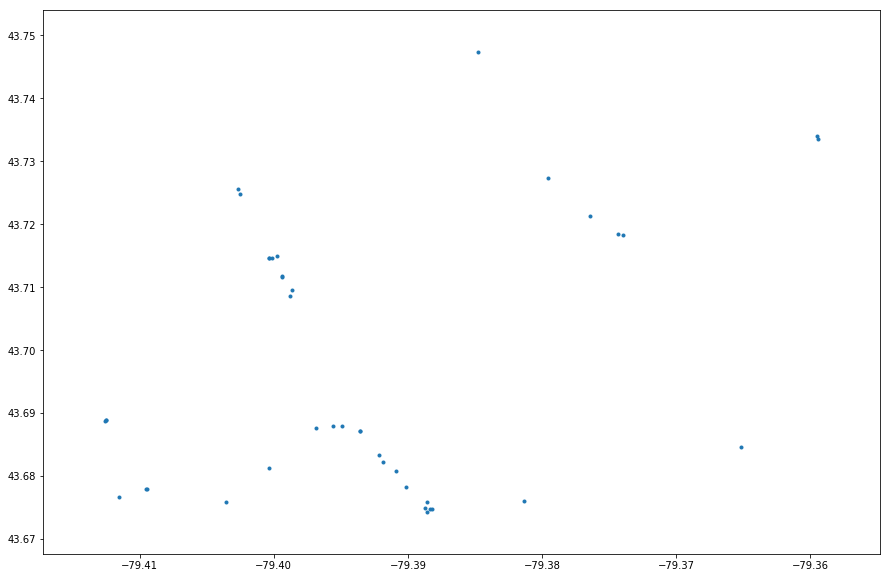

In [34]:
# Create the x and y coordinates for the scatter plot based off of longitude and latitude of the venues
x = df_venues_filter["lng"]
y = df_venues_filter["lat"]

# Display the scatter plot
fig = plt.figure(figsize=(15, 10))
plt.scatter(x, y, marker=".")

### Calculate the number of venues in each neighbourhood

In [35]:
df_venues_count = df_venues_filter.groupby("ID Number").count().reset_index()[["ID Number", "categories"]]

df_venues_count.rename(columns={"categories":"Venue Count"}, inplace = True)
df_venues_count

ID Number  Venue Count
0         41            7
1         96            5
2         98           16
3        101            3
4        103           10

### Create the k-means clustering

In [36]:
# initialize the k-means
k_means = KMeans(init=np.column_stack((df_select["Longitude"], df_select["Latitude"])), n_clusters=len(df_select.index), n_init=1)

In [37]:
# Crete X based on the x,y
X = np.column_stack((x,y))

In [38]:
# Fit the model with X
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True,
    init=array([[-79.3789 ,  43.73101],
       [-79.40801,  43.68185],
       [-79.41432,  43.69453],
       [-79.40604,  43.71721],
       [-79.37967,  43.68282]]),
    max_iter=300, n_clusters=5, n_init=1, n_jobs=None,
    precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)

In [39]:
# Get the labels
k_means_labels = k_means.labels_
k_means_labels

array([1, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 0, 0, 1, 1, 3, 3, 3, 1, 0, 0, 0,
       1, 1, 3, 3, 4, 4, 4, 4, 4, 4, 1, 1, 4, 0, 0, 2, 2, 3, 3],
      dtype=int32)

In [41]:
# Get the centers
k_means_centers = np.column_stack((df_select["Longitude"], df_select["Latitude"]))
k_means_centers

array([[-79.37890418,  43.73101314],
       [-79.40800665,  43.6818521 ],
       [-79.41431786,  43.69452576],
       [-79.40603941,  43.7172117 ],
       [-79.3796694 ,  43.68282043]])

### Display the k-means scatter plot

This will show the relation of all of the venues to the neighbourhoods.  Additionally, the neighbourhoods will be represented by the reatio of the population per venue; the larger the circle for the neighbourhood, the more opportunity there is.

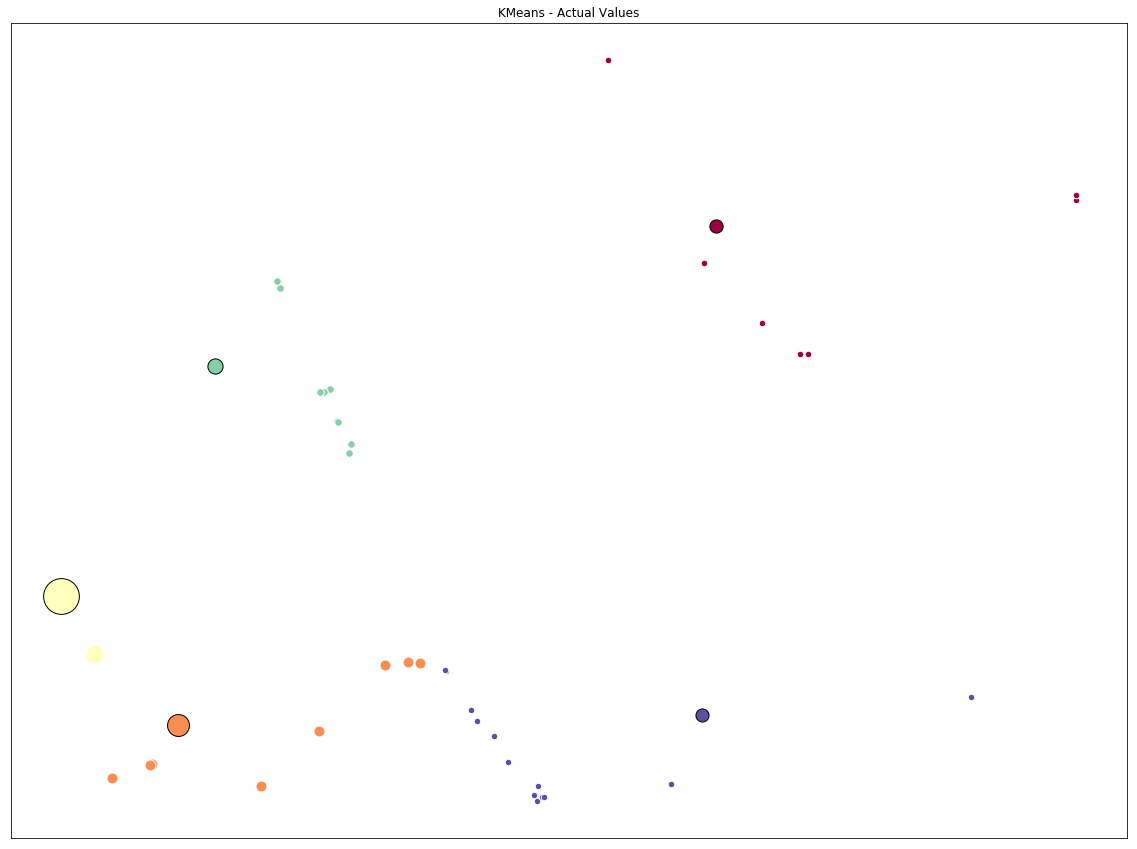

In [42]:
# initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(20, 15))

# colors uses a color map, which will produce an array of colors based on
# the number of labels. We use set(k_means_labels) to get the
# unique labels.
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

# create a plot
ax = fig.add_subplot(1, 1, 1)

# loop through the data and plot the datapoints and centroids.
# k will range from 0-3, which will match the number of clusters in the dataset.
for k, col in zip(range(0,len(df_select.index)), colors):

    # create a list of all datapoints, where the datapoitns that are 
    # in the cluster (ex. cluster 0) are labeled as true, else they are
    # labeled as false.
    my_members = (k_means_labels == k)
    
    # define the centroid, or cluster center.
    cluster_center = k_means_centers[k]
    
    # plot the datapoints with color col.
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".", \
            markersize=((df_select["Population"][k] / df_venues_count["Venue Count"][df_venues_count["ID Number"] == df_select["ID Number"][k]]) / 100 ))
    
    # plot the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], "o", markerfacecolor=col,  markeredgecolor="k", \
            markersize=((df_select["Population"][k] / df_venues_count["Venue Count"][df_venues_count["ID Number"] == df_select["ID Number"][k]]) / 100 ))

# title of the plot
ax.set_title("KMeans - Actual Values")

# remove x-axis ticks
ax.set_xticks(())

# remove y-axis ticks
ax.set_yticks(())

# show the plot
plt.show()

### Calculate the population per venue

In [43]:
# Merge the selected neighbourhoods and the count of venues per neighbourhood
df_analysis = pd.merge(df_select, df_venues_count, on = "ID Number")

# Remove the unnecessary data
df_analysis.drop(df_analysis.columns[[6,7,8]], axis=1, inplace=True)

# Calculate the population per venue
df_analysis["Population per Venue"] = round(df_analysis["Population"] / df_analysis["Venue Count"],0)
df_analysis

Name  ID Number  Population  Land Area  \
0  Bridle Path-Sunnybrook-York Mills         41      9266.0       8.91   
1                          Casa Loma         96     10968.0       1.93   
2                  Forest Hill South        101     10732.0       2.45   
3                Lawrence Park South        103     15179.0       3.24   
4                Rosedale-Moore Park         98     20923.0       4.65   

   Average Income  Radius  Venue Count  Population per Venue  
0        308010.0  1492.0            7                1324.0  
1        165047.0   695.0            5                2194.0  
2        204521.0   783.0            3                3577.0  
3        169203.0   900.0           10                1518.0  
4        207903.0  1078.0           16                1308.0

In [46]:
df_recommend = df_analysis.sort_values(by=["Population per Venue"], ascending = False)
df_recommend = df_recommend.iloc[0:3,:].reset_index(drop=True)
df_recommend

Name  ID Number  Population  Land Area  Average Income  \
0    Forest Hill South        101     10732.0       2.45        204521.0   
1            Casa Loma         96     10968.0       1.93        165047.0   
2  Lawrence Park South        103     15179.0       3.24        169203.0   

   Radius  Venue Count  Population per Venue  
0   783.0            3                3577.0  
1   695.0            5                2194.0  
2   900.0           10                1518.0

<div style="background-color:#f2f2f2; padding:5px;"><h2>5. Results and Discussion <a name="results"/></div>

The analysis started off by showing that there were five neighbourhoods that met the criteria (Bridle Path-Sunnybrook-York Mills, Casa Loma, Forest Hill South, Lawrence Park South, Rosedale-Moore Park).  We first display a choropleth map outlining each of the neighbourhoods to visually show the location of each.  This showed that the neighbourhoods were all within close proximity to each other and were located centrally.
    
Now that we focused on to candidate neighbourhoods, we overlay the current venues and can right aways start to see clusters of venues on the map.  From this point we move into showing actually clustering and how they relate to the neighbourhoods.  The size of the plots are directly linked to the population per current venue; the larger the plot, the larger the opportunity based on the population and venue saturation.
    
The analysis was able to determine the best potential locations and the top three candidate neighbourhoods are:
    
| Rank | Name                | Population | Land Area | Average Income | Current Venues | Population per Current Venue |
| :--: | ------------------- | :--------: | :-------: | -------------: | :------------: | :--------------------------: |
| 1    | Forest Hill South   | 10,732     | 2.45km²   | 204,521        | 3              | 3,577                        |
| 2    | Casa Loma           | 10,968     | 1.93km²   | 165,047        | 5              | 2,194                        |
| 3    | Lawrence Park South | 15,179     | 3.24km²   | 169,203        | 10             | 1,518                        |
    
As shown, Forest Hill South is not overly saturated with coffee shops and cafés.  It has a significantly higher population per current venue (3,577 people) as well as an average imcome of over $200k per year.  The average income far surpasses the client's minimum requirements.  

It would also be noteworthy to mention that the second and third rank neighbourhoods are within close proximity of Forest Hill South.  Casa Loma is located directly south and Lawrence Park South is located directly north of Forest Hill South.  This makes Forest Hill South stand out even further as it could draw in people from the surrounding neighbourhoods.
    
<hr>

<div style="background-color:#f2f2f2; padding:5px;"><h2>6. Conclusion <a name="conclusion"/></div>

The purpose of this project was to find suitable neighbourhoods for our client to opent their new shop and we were able to provide three potential neighbourhoods that are directly linked to each other making the location even more attractive.  By calculating the population per current venue, we were able to determine the venue saturation within each of the selected neighbourhoods.
    
Other characteristics will be used by the client in the final decision of location which may include real estate availability, zoning restrictions and overall attractiveness of the area (does it fit the brand).
    
<hr>